# Do left-handed people really die young?

# 1. Project info

**Project title**: Do left-handed people really die young?

**Name:** Lina Tran, Joel Ostblom, Madeleine Bonsma-Fisher, Ahmed Hasan

**E-mail:** lina.mntran@gmail.com, joel.ostblom@gmail.com, m.bonsma@mail.utoronto.ca, ahmed.hasan@mail.utoronto.ca

**GitHub username**: linanmt, joelostblom, mbonsma, aays

**Link to prior writing**: [Lina](https://github.com/UofTCoders/studyGroup/blob/gh-pages/lessons/python/classes/Classes_in_Python.ipynb), [Joel](https://github.com/UofTCoders/rcourse/blob/master/lec02-basic-r.Rmd), [Madeleine](https://github.com/UofTCoders/rcourse/blob/master/lec07-pop-models.Rmd), [Ahmed](https://github.com/UofTCoders/studyGroup/blob/gh-pages/lessons/r/dplyrmagrittr/lesson.Rmd) 

**Short description**: Left-handed people are commonly believed to die younger than right-handed people. 
    This notebook outlines a simple statistical explanation for this alarming belief.

#### Long description ####

A [1991 study](https://www.nejm.org/doi/full/10.1056/NEJM199104043241418) reported that left-handed people die on average 9 years earlier than right-handed people. This result was much-disputed, and it turns out to be the result of a simple statistical mistake (described in this [BBC article](www.bbc.com/news/magazine-23988352)). The reported rates of left-handedness have increased from just 3% in the early 1900s to about 11% today, which means that older people are much more likely to be reported as right-handed than left-handed, and so looking at a sample of recently deceased people will have more old right-handers. In this Python project, we will explore the impact of this mistake using age distribution data to see if we can reproduce a difference in average age at death purely from the changing rates over time. This notebook uses `pandas` and Bayesian statistics to analyze the probability of being a certain age at death given that you are reported as left-handed or right-handed.

#### Datasets used ####

This project uses two datasets: [death distribution data](https://www.cdc.gov/nchs/data/statab/vs00199_table310.pdf) for the United States from the year 1999 (source website [here](https://www.cdc.gov/nchs/nvss/mortality_tables.htm)) and rates of left-handedness data from a [1992 paper by Gilbert and Wysocki](https://www.ncbi.nlm.nih.gov/pubmed/1528408). I scraped the death distribution data using [tabula](https://tabula.technology/) and saved the first three columns. I scraped data points approximately from Figure 2 in the Gilbert and Wysocki paper using this [web plot digitizer](https://apps.automeris.io/wpd/). 

Death distribution data:
`cdc_vs00199_table310.tsv`: https://gist.github.com/mbonsma/2f4076aab6820ca1807f4e29f75f18ec

Left-handedness data:
`lh_data.csv`: https://gist.github.com/mbonsma/8da0990b71ba9a09f7de395574e54df1

#### Assumed student background ####

The student can handle python control structures like `if` statements and `for` loops. The student has used `pandas` and can load in and inspect `csv` files. She knows how to select columns and subset rows using the `[]` operator and understand vectorized operators (like that `+` is vectorized). The student has produced line and scatter plots using `matplotlib`. The student knows how to create custom functions using the `def` syntax. The student is familiar with the concept of a probability distribution, knows how to calculate the mean of a probability distribution, and knows Bayes' rule for conditional probability.

---

## 1. Where are the old left-handed people?

A National Geographic survey in 1986 resulted in over a million responses that included age, sex, and hand preference for throwing and writing. Researchers Avery Gilbert and Charles Wysocki analyzed this data and noticed that rates of left-handedness were around 13% for people younger than 40 but decreased with age to about 5% by the age of 80. 

They concluded based on analysis of a subgroup of people who throw left-handed but write right-handed that this age-dependence was primarily due to changing social acceptibility of left-handedness. This means that the rates aren't a factor of *age* specifically but rather of the *year you were born*, and if the same study was done today, we should expect a shifted version of the same distribution as a function of age.

Ultimately, we'll see what effect this changing rate has on the apparent mean age of death of left-handed people, but let's start by plotting the rates of left-handedness as a function of age.


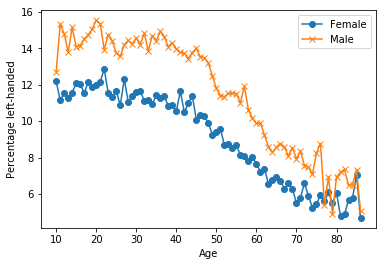

In [2]:
# load the left-handedness data and create a scatter plot

import pandas as pd
from matplotlib import pyplot as plt

data_url = "https://gist.githubusercontent.com/mbonsma/8da0990b71ba9a09f7de395574e54df1/raw/aec88b30af87fad8d45da7e774223f91dad09e88/lh_data.csv"
lefthanded_data = pd.read_csv(data_url, sep = ',')

# this makes the plot appear in the notebook
%matplotlib inline

fig, ax = plt.subplots()
ax.plot('Age', 'Female', data = lefthanded_data, marker='o')
ax.plot('Age','Male', data = lefthanded_data, marker = 'x')

ax.legend()
ax.set_xlabel("Age")
ax.set_ylabel("Percentage left-handed")

## 2. Rates of left-handedness over time

Let's convert this data into a plot of the rates of left-handedness as a function of the year you were born, and average over male and female to get a single rate for both sexes.

We want the percentage of people alive in 1986 who are left-handed as a function of the year they were born. 

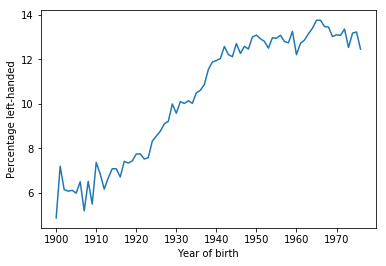

In [3]:
# create a new column for birth year of each age
lefthanded_data['Year'] = 1986 - lefthanded_data['Age'] # the study was done in 1986

# create a new column for the average of male and female
lefthanded_data['Mean_lh'] = lefthanded_data[['Female', 'Male']].mean(axis = 1)

fig, ax = plt.subplots()
ax.plot('Year', 'Mean_lh', data = lefthanded_data)
ax.set_xlabel("Year of birth")
ax.set_ylabel("Percentage left-handed")

## 3. Applying Bayes' rule

**Bayes' rule** or **Bayes' theorem** is a statement about conditional probability which allows us to update our beliefs after seeing evidence. The probability of outcome or event $A$, given that outcome or event $B$ has happened (or is true) is not the same as the probability of outcome $B$ given that outcome $A$ has happened. We need to take into account the **prior** probability that $A$ has happened ($P(A)$). Bayes' rule can be written as follows:

$$P(A | B) = \frac{P(B|A) P(A)}{P(B)}$$

The numerator on the right-hand side can also be understood as the probability that both $A$ and $B$ occur.

The quantity we ultimately want to calculate is the probability of dying at a particular age $A$, *given that* your family thinks you are left-handed. Let's write this in shorthand as $P(A | LH)$. We also want the same quantity for right-handers: $P(A | RH)$. We can figure out or approximate the other three quantities to find out what difference in age of death we might expect purely from the changing rates of left-handedness plotted above.

Here's Bayes' rule in the context of our discussion:

$$P(A | LH) = \frac{P(LH|A) P(A)}{P(LH)}$$

$P(LH | A)$ is the probability that you are left-handed *given that* you died at age $A$. $P(A)$ is the overall probability of dying at age $A$, and $P(LH)$ is the overall probability of being left-handed. We will now calculate each of these three quantities. 

In [81]:
# create a function for P(LH | A)

def P_lh_given_A(age_of_death, study_year = 1990):
    """
    P(LH | age of death), calculated based on the reported rates of left-handedness
    The original study that reported a 9-year age of death difference was done in 1990. 
    """
    
    # Assume the rates before and after the start of the dataset are the mean of the 10 neighbouring points
    early_1900s_rate = lefthanded_data['Mean_lh'][-10:].mean()
    late_1900s_rate = lefthanded_data['Mean_lh'][:10].mean()
    
    youngest_age = study_year - 1986 + 10 # the youngest age in the dataset is 10
    oldest_age = study_year - 1986 + 86 # the oldest age in the datset is 86
    
    if age_of_death < youngest_age:
        return late_1900s_rate / 100 # make it a probability, not a percentage
    elif age_of_death > oldest_age:
        return early_1900s_rate / 100
    else:
        return float(lefthanded_data.loc[lefthanded_data['Year'] == study_year - age_of_death]['Mean_lh']) / 100


## 4. When do people normally die?

To estimate the probability of living to an age $A$, we can use data that gives the number of people who died in a given year and how old they were to create a distribution of ages of death. If we normalize the numbers to the total number of people who died, we can think of this data as a probability distribution giving the probability of dying at age $A$. The data we'll use for this is from the entire US for the year 1999 - the closest I could find for the time range we're interested in. 

In this block, we'll load in the death distribution data and plot it. The first column is the age, and the other columns are the number of people who died at that age. 

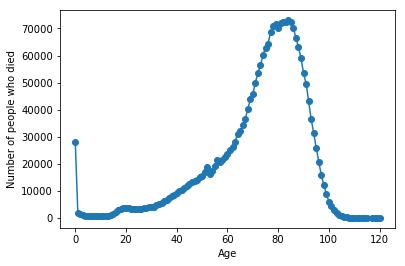

In [82]:
data_url = "https://gist.githubusercontent.com/mbonsma/2f4076aab6820ca1807f4e29f75f18ec/raw/62f3ec07514c7e31f5979beeca86f19991540796/cdc_vs00199_table310.tsv"

death_distribution_data = pd.read_csv(data_url, sep = '\t', skiprows=[1])

fig, ax = plt.subplots()
ax.plot('Age', 'Both Sexes', data = death_distribution_data, marker='o')

ax.set_xlabel("Age")
ax.set_ylabel("Number of people who died")

## 5. What's the overall probability of left-handedness among recently deceased people?

In the previous code block we loaded data to give us $P(A)$, and now we need $P(LH)$. $P(LH)$ is the probability that a person who died in our particular study year is left-handed, assuming we know nothing else about them. This is the average left-handedness in the population of deceased people, and we can calculate it by summing up all of the left-handedness probabilities for each age, weighted with the number of deceased people at each age, then divided by the total number of deceased people to get a probability. In equation form, this is what we're calculating, where $N(A)$ is the number of people who died at age $A$ (given by the dataframe `death_distribution_data`:

$$P(LH) = \frac{\sum_{\text{A}} P(LH | A) N(A)}{\sum_{\text{A}} N(A)}$$

In [84]:
# sum over P_lh for each age group
import numpy as np

def P_lh(death_distribution_data):
    """
    Overall probability of being left-handed if you died in the study year
    P_lh = P(LH | Age of death) P(Age of death) + P(LH | not A) P(not A) = sum over ages 
    """
    
    # a variable to hold our sum
    p = 0
    
    # drop NaN values from the 'Both Sexes' column
    death_distribution_data = death_distribution_data.dropna(subset = ["Both Sexes"])
    
    for age in death_distribution_data['Age']:
        if age < 6:
            continue # skip child deaths

        p += death_distribution_data['Both Sexes'][age]*P_lh_given_A(age)
        
    p = p/np.sum(death_distribution_data.loc[6:, 'Both Sexes']) # normalize to total number of people in distribution
    
    return p

print(P_lh(death_distribution_data))

0.0768970328313


## 6. Putting it all together: the conditional probability of dying while left-handed

Now we have the means of calculating all three quantities we need: $P(A)$, $P(LH)$, and $P(LH | A)$. We can combine all three using Bayes' rule to get $P(A | LH)$, the probability of being age $A$ at death (in the study year) given that you're left-handed. To make this answer meaningful, though, we also want to compare it to $P(A | RH)$, the probability of being age $A$ at death given that you're right-handed. 

<!--Notice that I was careful not to call these "probability of dying at age $A$", since that's not actually what we're calculating: we use the exact same death distribution data for each. -->

In [87]:
def P_A_given_lh(age_of_death, death_distribution_data):
    P_A = death_distribution_data['Both Sexes'][age_of_death] / np.sum(death_distribution_data['Both Sexes'])
    
    P_left = P_lh(death_distribution_data)
    
    P_lh_A = P_lh_given_A(age_of_death)
    
    return P_lh_A*P_A/P_left

def P_A_given_rh(age_of_death, death_distribution_data):
    P_A = death_distribution_data['Both Sexes'][age_of_death] / np.sum(death_distribution_data['Both Sexes'])
    
    # either you're left-handed or right-handed, so these sum to 1
    P_right = 1- P_lh(death_distribution_data) 
    P_rh_A = 1-P_lh_given_A(age_of_death)
    
    return P_rh_A*P_A/P_right

## 7. Plotting the distributions of conditional probabilities

Now that we have functions to calculate the probability of being age $A$ at death given that you're left-handed or right-handed, let's plot these probabilities for a range of ages of death from 6 to 120. 

Notice that the left-handed distribution has a bump below age 70: of the pool of deceased people, left-handed people are more likely to be younger. 

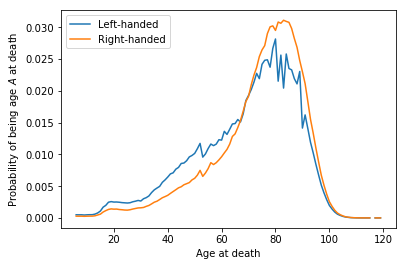

In [94]:
ages = np.arange(6,120,1)

left_handed_probability = []
right_handed_probability = []

for A in ages:
    left_handed_probability.append(P_A_given_lh(A, death_distribution_data))
    right_handed_probability.append(P_A_given_rh(A, death_distribution_data))

fig, ax = plt.subplots()

ax.plot(ages, left_handed_probability, label = "Left-handed")
ax.plot(ages, right_handed_probability, label = "Right-handed")
ax.legend()
ax.set_xlabel("Age at death")
ax.set_ylabel(r"Probability of being age $A$ at death")

## 8. Moment of truth: average age of the left-handed and right-handed groups at death

Finally, let's compare our results with the original study that found that left-handed people were 9 years younger at death on average. We can do this by calculating the mean of these probability distributions in the same way we calculated $P(LH)$ earlier, weighting the probability distribution by age and summing over the result.

$$\text{Average age of left-handed people at death} = \sum_A A P(A | LH)$$

$$\text{Average age of right-handed people at death} = \sum_A A P(A | RH)$$

In [111]:
# calculate average ages for left-handed and right-handed groups

average_lh_age =  np.nansum(ages*np.array(left_handed_probability))
average_rh_age =  np.nansum(ages*np.array(right_handed_probability))

print(round(average_lh_age,1))
print(round(average_rh_age,1))
print("The difference in average ages is " + str(round(average_rh_age - average_lh_age, 1)) + " years.")

67.9
72.7
The difference in average ages is 4.8 years.


## 9. Final comments

We got a pretty big age gap between left-handed and right-handed people, purely as a result of the changing rates of left-handedness in the population, but our number is still less than the 9-year gap measured in the study. It's possible that some of the approximations we made are the cause: 

1. We used death distribution data from almost 10 years after the study (1999 instead of 1991), and we used death data from the entire United States instead of California alone (which was the original study). 
2. We extrapolated the left-handedness survey results to older and younger age groups, but it's possible our extrapolation wasn't close enough to the true rates for those ages. 

One thing we can do pretty easily is figure out how much variability you would expect to encounter in the age difference purely because of random sampling: if you take a smaller sample of recently deceased people and assign handedness with the probabilities of the survey, what does that distribution look like? How often would we encounter an age gap of 9 years using the same data and assumptions? Read on to find out!

## 10. Random sampling to create 'experimental data'

The 1991 experiment had 987 deceased people with which to calculate their mean. That's a lot, but it's much less than the millions we used above. Let's create test datasets by sampling randomly from the death distribution and randomly assigning handedness using the probability of left-handedness given age defined above. 

In [192]:
# create a list of ages of deceased people to draw from

ages = []

for age in (death_distribution_data['Age']):
    num_deceased = death_distribution_data[death_distribution_data['Age'] == age]['Both Sexes']
    if age < 6:
        continue
    vec = np.ones((int(num_deceased)))*age
    ages.extend(vec)

# draw a subsample
n = 987
ages_sample = np.random.choice(ages, size=n)

In [193]:
# alternate method

n = 987 # size of the population sample (number of dead people)

# step 1: draw n random numbers from a uniform distribution
random_nums = np.random.random(size = n)

# step 2: assign ages based on the random numbers, weighting by death distribution data

cumulative_death_distribution = np.cumsum(death_distribution_data['Both Sexes'])

end_val = np.max(cumulative_death_distribution)
index_vals = random_nums*end_val

ages_sample = []
for i in index_vals:
    nearest_age = np.argmin(np.abs(cumulative_death_distribution - i))
    ages_sample.append(nearest_age)

In [188]:
# assign handedness randomly with probabilities based on age of death

handedness = []
for age in ages_sample:
    # draw a random number and choose lh or rh based on incidence rates
    P_left = P_lh_given_A(age)
    rand = np.random.random()
    if rand < P_left:
        handedness.append(False) # 0 for left-handed
    else:
        handedness.append(True) # 1 for right-handed

handedness = np.array(handedness)
ages_sample = np.array(ages_sample)

In [189]:
mean_rh_age = np.mean(ages_sample[handedness])
mean_lh_age = np.mean(ages_sample[np.logical_not(handedness)])

print(round(mean_lh_age,1))
print(round(mean_rh_age,1))

print("The difference in average ages is " + str(round(mean_rh_age - mean_lh_age, 1)) + " years.")

66.5
72.2
The difference in average ages is 5.7 years.


In [206]:
# Now do this lots of times and make a histogram of the age differences
from tqdm import tqdm
n = 987 # size of the population sample (number of dead people)
cumulative_death_distribution = np.cumsum(death_distribution_data['Both Sexes'])
end_val = np.max(cumulative_death_distribution)

age_differences = []

num_iterations = 500

for count in tqdm(range(num_iterations)):

    ages_sample = np.random.choice(ages, size=n) # ages is the full list of ages from above

    handedness = []
    for age in ages_sample:
        P_left = P_lh_given_A(age)
        rand = np.random.random()
        if rand < P_left:
            handedness.append(False) # 0 for left-handed
        else:
            handedness.append(True) # 1 for right-handed
        
    
    handedness = np.array(handedness)
    
    mean_rh_age = np.mean(ages_sample[handedness])
    mean_lh_age = np.mean(ages_sample[np.logical_not(handedness)])
    
    age_differences.append(mean_rh_age - mean_lh_age)

100%|██████████| 500/500 [07:15<00:00,  1.15it/s]


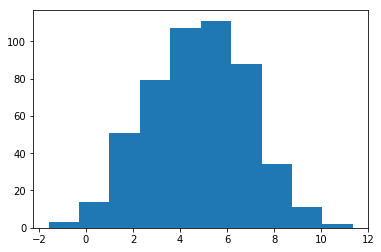

In [207]:
fig, ax = plt.subplots()

pl = ax.hist(age_differences)

In [210]:
# fraction of times we would observe an age difference of 9 or greater
len(np.where(np.array(age_differences) >= 9)[0])/500

0.022

Extensions: sampling and simulations, splitting by sex